# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не хватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

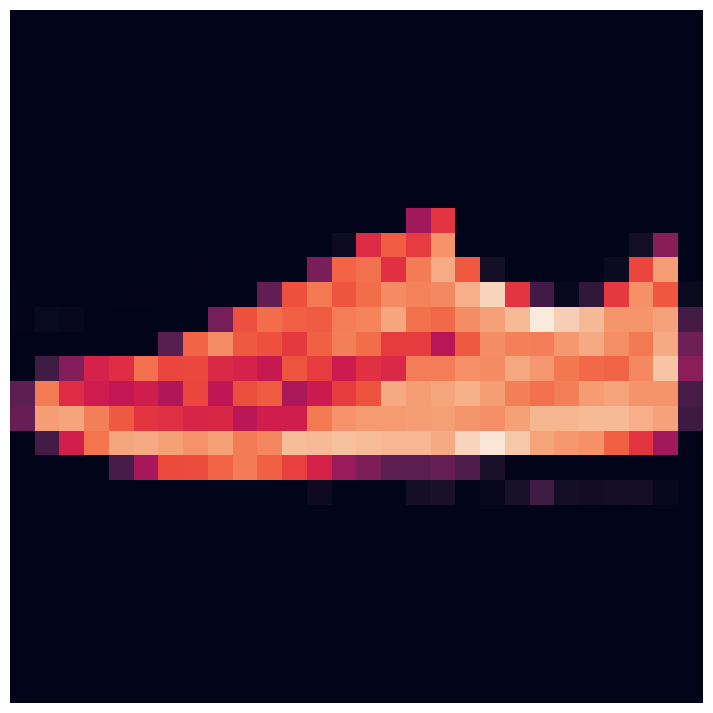

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

Посмотрим, сколько представителей каждого класса:

In [6]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([ 93, 102,  95, 121,  96,  98, 101,  79, 109, 106]))

Изобразим по 1 картинке из каждого класса:

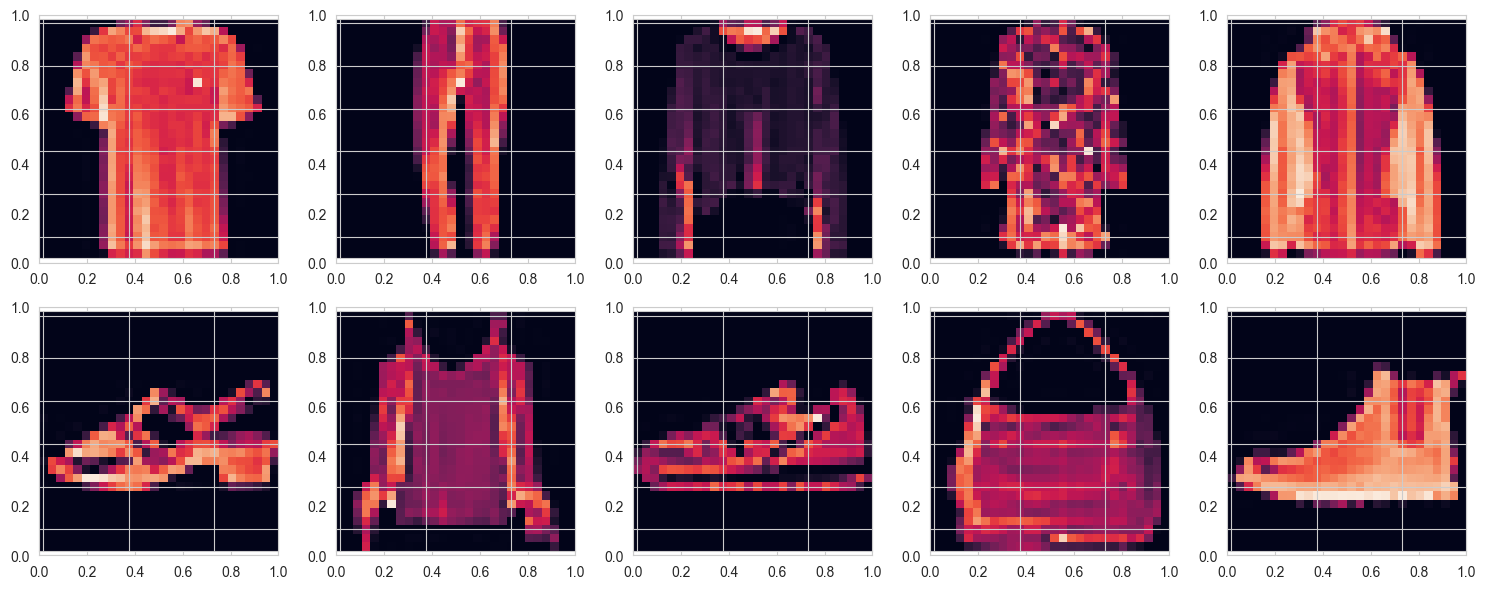

In [7]:
rows = 2
columns = 5

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))
cl = 0

for num in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, num) 
    plt.imshow(X[y == str(cl)][10].reshape(28, 28, 1))   
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    cl += 1
    
fig.tight_layout()

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

Распределение по классам:

In [8]:
unique = list(unique)
counts = list(counts)

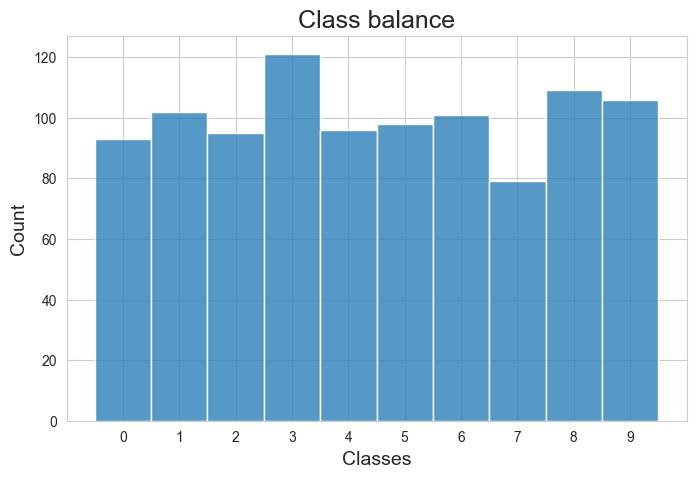

In [9]:
fig2, axes = plt.subplots(figsize=(8,5))
fig2 = sns.histplot(x = sorted(y))
plt.xlabel("Classes", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.title("Class balance", fontsize = 18)
plt.show(fig)

Классы сбалансированы

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=SEED, 
                                                    test_size=0.2)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [11]:
binary_train_X = X_train[(y_train == '0') | (y_train == '1')]
binary_train_y = y_train[(y_train == '0') | (y_train == '1')]

In [12]:
len(binary_train_X), len(binary_train_y)

(159, 159)

In [13]:
binary_test_X = X_test[(y_test == '0') | (y_test == '1')]
binary_test_y = y_test[(y_test == '0') | (y_test == '1')]

In [14]:
len(binary_test_X), len(binary_test_y)

(36, 36)

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [17]:
knn_classifier = KNNClassifier(k=3)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

Я вставила код из `knn.py` и `metrics.py` в ноутбук, чтобы было удобнее здесь запускать:

In [16]:
import numpy as np


class KNNClassifier:
    """
    K-neariest-neighbor classifier using L1 loss
    """
    
    def __init__(self, k=1):
        self.k = k
    

    def fit(self, X, y):
        self.train_X = X
        self.train_y = y


    def predict(self, X, n_loops = 0):
        """
        Uses the KNN model to predict clases for the data samples provided
        
        Arguments:
        X, np array (num_samples, num_features) - samples to run
           through the model
        num_loops, int - which implementation to use

        Returns:
        predictions, np array of ints (num_samples) - predicted class
           for each sample
        """
        
        if n_loops == 0:
            distances = self.compute_distances_no_loops(X)
        elif n_loops == 1:
            distances = self.compute_distances_one_loop(X)
        else:
            distances = self.compute_distances_two_loops(X)
        
        if len(np.unique(self.train_y)) == 2:
            return self.predict_labels_binary(distances)
        else:
            return self.predict_labels_multiclass(distances)


    def compute_distances_two_loops(self, X):
        """
        Computes L1 distance from every sample of X to every training sample
        Uses simplest implementation with 2 Python loops

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        """
        distances = []
        
        for row_test in X:
            distances_test = []
            for row_train in self.train_X:
                distances_test.append(abs(row_train - row_test).sum())    
            distances.append(np.array(distances_test))
            
        return np.array(distances)


    def compute_distances_one_loop(self, X):
        """
        Computes L1 distance from every sample of X to every training sample
        Vectorizes some of the calculations, so only 1 loop is used

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        """

        distances = []
        
        for row_test in X:
            distances_test = []
            row_test_dim = [row_test]*len(self.train_X)
            distances_test = np.absolute(row_test_dim - self.train_X).sum(axis=1)
            distances.append(distances_test)
            
        return np.array(distances)


    def compute_distances_no_loops(self, X):
        """
        Computes L1 distance from every sample of X to every training sample
        Fully vectorizes the calculations using numpy

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        """

        return np.absolute(self.train_X - X[:,None]).sum(axis = 2)


    def predict_labels_binary(self, distances):
        """
        Returns model predictions for binary classification case
        
        Arguments:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        Returns:
        pred, np array of bool (num_test_samples) - binary predictions 
           for every test sample
        """

        n_train = distances.shape[1]
        n_test = distances.shape[0]
        prediction = np.zeros(n_test)
        ind_list = []
        value_list = []

        if self.k == 1:
            for i in range(n_test):
                min_ind = distances[i].argmin()
                prediction[i] = int(self.train_y[min_ind])
        elif self.k > 1:
            for i in range(n_test):
                min_values = sorted(distances[i])[:self.k]
                for each in min_values:
                    ind_list.append(np.where(distances[i] == each)[0][0])
                for ind in ind_list:
                    value_list.append(self.train_y[ind])
                unique, counts = np.unique(value_list, return_counts=True)
                unique_counts = {v:m for m,v in zip(unique, counts)}
                prediction[i] = unique_counts[max(unique_counts)]
    
        return prediction


    def predict_labels_multiclass(self, distances):
        """
        Returns model predictions for multi-class classification case
        
        Arguments:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        Returns:
        pred, np array of int (num_test_samples) - predicted class index 
           for every test sample
        """

        n_train = distances.shape[0]
        n_test = distances.shape[0]
        prediction = np.zeros(n_test, np.int)

        ind_list = []
        value_list = []

        if self.k == 1:
            for i in range(n_test):
                min_ind = distances[i].argmin()
                prediction[i] = int(self.train_y[min_ind])
        elif self.k > 1:
            for i in range(n_test):
                min_values = sorted(distances[i])[:self.k]
                for each in min_values:
                    ind_list.append(np.where(distances[i] == each)[0][0])
                for ind in ind_list:
                    value_list.append(self.train_y[ind])
                unique, counts = np.unique(value_list, return_counts=True)
                unique_counts = {v:m for m,v in zip(unique, counts)}
                prediction[i] = unique_counts[max(unique_counts)]
    
        return prediction


В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [18]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [19]:
dists

array([[32969., 31290., 19203., ..., 62868., 37755., 19107.],
       [67715., 66710., 62803., ..., 24482., 58947., 74821.],
       [26156., 26141., 18322., ..., 62289., 33226., 15722.],
       ...,
       [20831., 12290., 40173., ..., 63980., 42463., 36273.],
       [18078., 14331., 33886., ..., 60359., 41702., 31338.],
       [41413., 48004., 29329., ..., 53528., 41369., 34099.]])

In [20]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [21]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [22]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

45.1 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
25.1 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.2 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [23]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

In [24]:
np.mean(prediction)

0.7777777777777778

In [25]:
binary_test_y = binary_test_y.astype(float)
binary_test_y

array([1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 0.])

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [26]:
# TODO: binary_classification_metrics in metrics.py

In [27]:
import numpy as np


def binary_classification_metrics(y_pred, y_true):
    """
    Computes metrics for binary classification
    Arguments:
    y_pred, np array (num_samples) - model predictions
    y_true, np array (num_samples) - true labels
    Returns:
    precision, recall, f1, accuracy - classification metrics
    """

    # TODO: implement metrics!
    # Some helpful links:
    # https://en.wikipedia.org/wiki/Precision_and_recall
    # https://en.wikipedia.org/wiki/F1_score

    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i in range(len(y_pred)):
        if (y_pred[i] == 1) and (y_true[i] == 1):
            tp += 1
        elif (y_pred[i] == 1) and (y_true[i] == 0):
            fp += 1
        elif (y_pred[i] == 0) and (y_true[i] == 1):
            fn += 1
        elif (y_pred[i] == 0) and (y_true[i] == 0):
            tn += 1
        
    if ((tp + fp) != 0):
        precision = tp/(tp + fp)
    else:
        precision = 0
        print('Division by zero!')
        
    if ((tp + fn) != 0):
        recall = tp/(tp + fn)
    else:
        recall = 0
        print('Division by zero!')
        
    if ((tp + tn + fp + fn) != 0):
        accuracy = (tp + tn)/(tp + tn + fp + fn)
    else:
        accuracy = 0
        print('Division by zero!')
        
    if (( 2*tp + fp + fn) != 0):
        f1_score = 2*tp/( 2*tp + fp + fn)
    else:
        f1_score = 0
        print('Division by zero!')
        
        
    return precision, recall, accuracy, f1_score
    
    

def multiclass_accuracy(y_pred, y_true):
    """
    Computes metrics for multiclass classification
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true labels
    Returns:
    accuracy - ratio of accurate predictions to total samples
    """

    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i in range(len(y_pred)):
        if (y_pred[i] == 1) and (y_true[i] == 1):
            tp += 1
        elif (y_pred[i] == 1) and (y_true[i] == 0):
            fp += 1
        elif (y_pred[i] == 0) and (y_true[i] == 1):
            fn += 1
        elif (y_pred[i] == 0) and (y_true[i] == 0):
            tn += 1
        
    if ((tp + tn + fp + fn) != 0):
        accuracy = (tp + tn)/(tp + tn + fp + fn)
    else:
        accuracy = 0
        print('Division by zero!')
        
    return accuracy


def r_squared(y_pred, y_true):
    """
    Computes r-squared for regression
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true values
    Returns:
    r2 - r-squared value
    """

    ver = 0
    nis = 0
    mean_true = np.mean(y_true)

    for i in range(len(y_pred)):
        ver += np.power((y_true[i] - y_pred[i]), 2)
        nis += np.power((y_true[i] - mean_true), 2)

    r_2 = 1 - ver/nis
    return r_2


def mse(y_pred, y_true):
    """
    Computes mean squared error
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true values
    Returns:
    mse - mean squared error
    """
    
    ver = 0
    n = len(y_true)
    
    for i in range(len(y_pred)):
        ver += np.power((y_true[i] - y_pred[i]), 2)
    
    mse = ver/n
    return mse


def mae(y_pred, y_true):
    """
    Computes mean absolut error
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true values
    Returns:
    mae - mean absolut error
    """

    ver = 0
    n = len(y_true)
    
    for i in range(len(y_pred)):
        ver += abs(y_true[i] - y_pred[i])
    
    mae = ver/n
    return mae
    

In [28]:
binary_classification_metrics(prediction, binary_test_y)

(0.5714285714285714,
 0.7619047619047619,
 0.5277777777777778,
 0.6530612244897959)

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [30]:
print(f'precision_score = {precision_score(binary_test_y, prediction)}')
print(f'recall_score = {recall_score(binary_test_y, prediction)}')
print(f'accuracy_score = {accuracy_score(binary_test_y, prediction)}')
print(f'f1_score = {f1_score(binary_test_y, prediction,)}')

precision_score = 0.5714285714285714
recall_score = 0.7619047619047619
accuracy_score = 0.5277777777777778
f1_score = 0.6530612244897959


Все значения метрик совпадают)

### Подбор оптимального k

Чтобы подобрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `find_best_k` прямо в ноутбуке.

Я реализую 2 функции для подбора оптимального значения параметра k для задачи классификации и регрессии: `find_best_k_class` и `find_best_k_regres` 

In [75]:
def find_best_k_class(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []
    
    for k_value in params:
        print("k_value ", k_value)
        knn_classifier = KNNClassifier(k = k_value)
        knn_classifier.fit(X_train, y_train)
        predictions_train = knn_classifier.predict(X_train, n_loops=1)
        predictions_test = knn_classifier.predict(X_test, n_loops=1)
        
        metric_test = metric(predictions_test, y_test)
        test_metrics.append(metric_test)
        
        metric_train = metric(predictions_train, y_train)
        train_metrics.append(metric_train)
        
    return train_metrics, test_metrics

def find_best_k_regres(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KNeighborsRegressor
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []
    
    for k_value in params:
        print("k_value ", k_value)
        knn_regressor = KNeighborsRegressor(n_neighbors = k_value)
        knn_regressor.fit(X_train, y_train)
        predictions_train = knn_regressor.predict(X_train)
        predictions_test = knn_regressor.predict(X_test)
        
        metric_test = metric(predictions_test, y_test)
        test_metrics.append(metric_test)
        
        metric_train = metric(predictions_train, y_train)
        train_metrics.append(metric_train)
        
    return train_metrics, test_metrics

In [32]:
params = [1, 2, 4, 5, 8, 10, 30] 
train_metrics, test_metrics = find_best_k_class(binary_train_X, binary_train_y.astype(float), binary_test_X, binary_test_y.astype(float), 
                                          params, precision_score)

k_value  1
k_value  2
k_value  4
k_value  5
k_value  8
k_value  10
k_value  30


В качестве метрики была выбрана **precision score**, так как она показывает способность модели отличать один класс от другого.

In [33]:
train_metrics

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [34]:
test_metrics

[1.0,
 0.6666666666666666,
 0.8095238095238095,
 0.8571428571428571,
 0.8095238095238095,
 0.8095238095238095,
 0.8095238095238095]

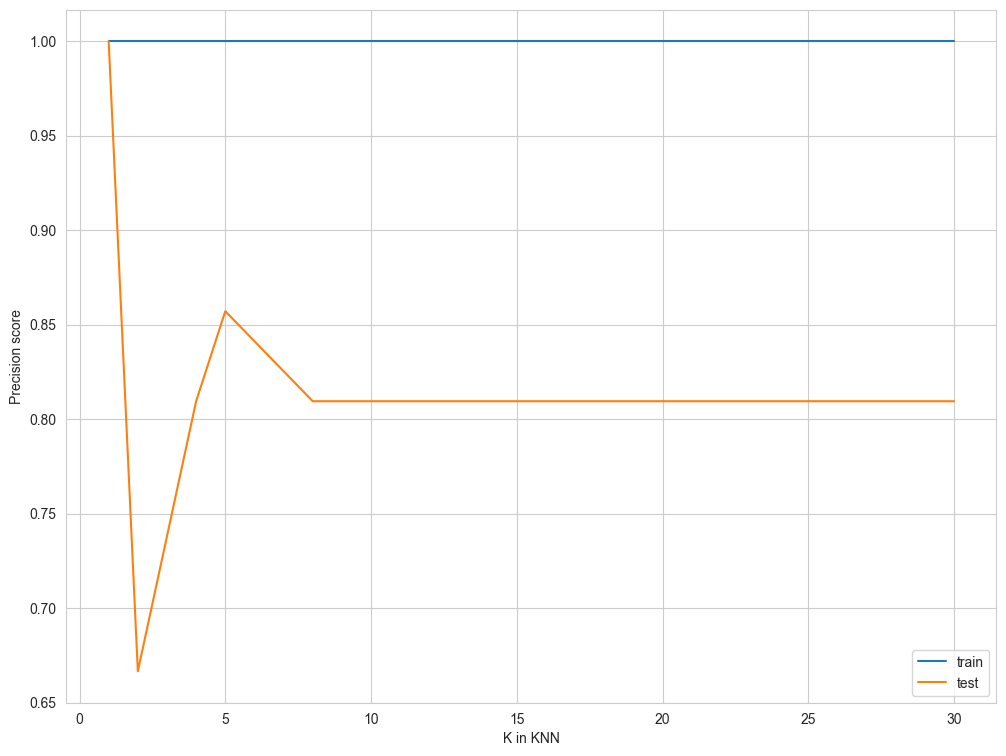

In [35]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Precision score");

На тестовом датасете лучшее значение выбранной метрики показвает модель со значением k = 5

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [36]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

/var/folders/_y/cf4dygc14qx9g7l_tls72w940000gn/T/ipykernel_16554/1574034217.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction = np.zeros(n_test, np.int)


Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [37]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test.astype(float))

1.0

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [38]:
params = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
train_metrics, test_metrics = find_best_k_class(X_train.astype(float), 
                                          y_train.astype(float), 
                                          X_test.astype(float), 
                                          y_test.astype(float), 
                                          params, multiclass_accuracy)

k_value  1


/var/folders/_y/cf4dygc14qx9g7l_tls72w940000gn/T/ipykernel_16554/1574034217.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction = np.zeros(n_test, np.int)


k_value  2
k_value  3
k_value  4
k_value  5
k_value  6
k_value  7
k_value  8
k_value  9
k_value  10


In [39]:
train_metrics

[1.0,
 0.38461538461538464,
 0.45454545454545453,
 0.5,
 0.5294117647058824,
 0.45454545454545453,
 0.46153846153846156,
 0.5,
 0.5,
 0.48148148148148145]

In [40]:
test_metrics

[1.0,
 0.5,
 0.4,
 0.4,
 0.5,
 0.5,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333]

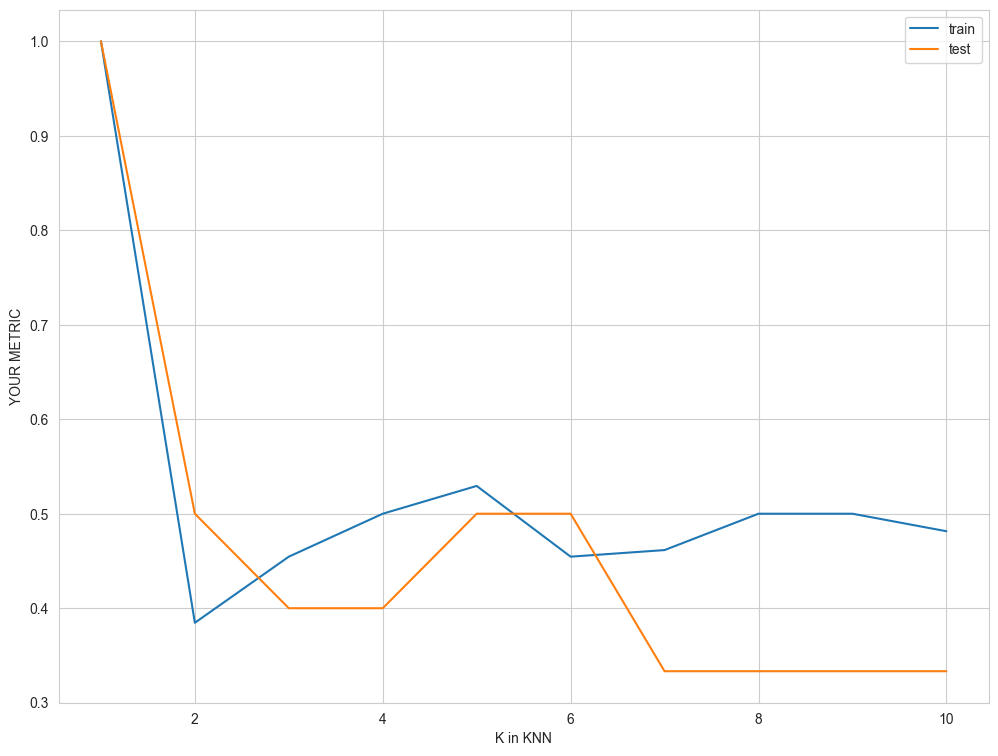

In [41]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [42]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [43]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [44]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


Пропущенных значений нет, все значения признаков приведены к одному типу

In [46]:
X.std()

age    0.047619
sex    0.047619
bmi    0.047619
bp     0.047619
s1     0.047619
s2     0.047619
s3     0.047619
s4     0.047619
s5     0.047619
s6     0.047619
dtype: float64

В данном случае не нужна стандартизация данных, т.к. стандартное отклонение всех признаков одинаковое, поэтому изменение одного признака приведет к такому же изменению остальных признаков.

Посмотрим на **распределение каждого признака**:

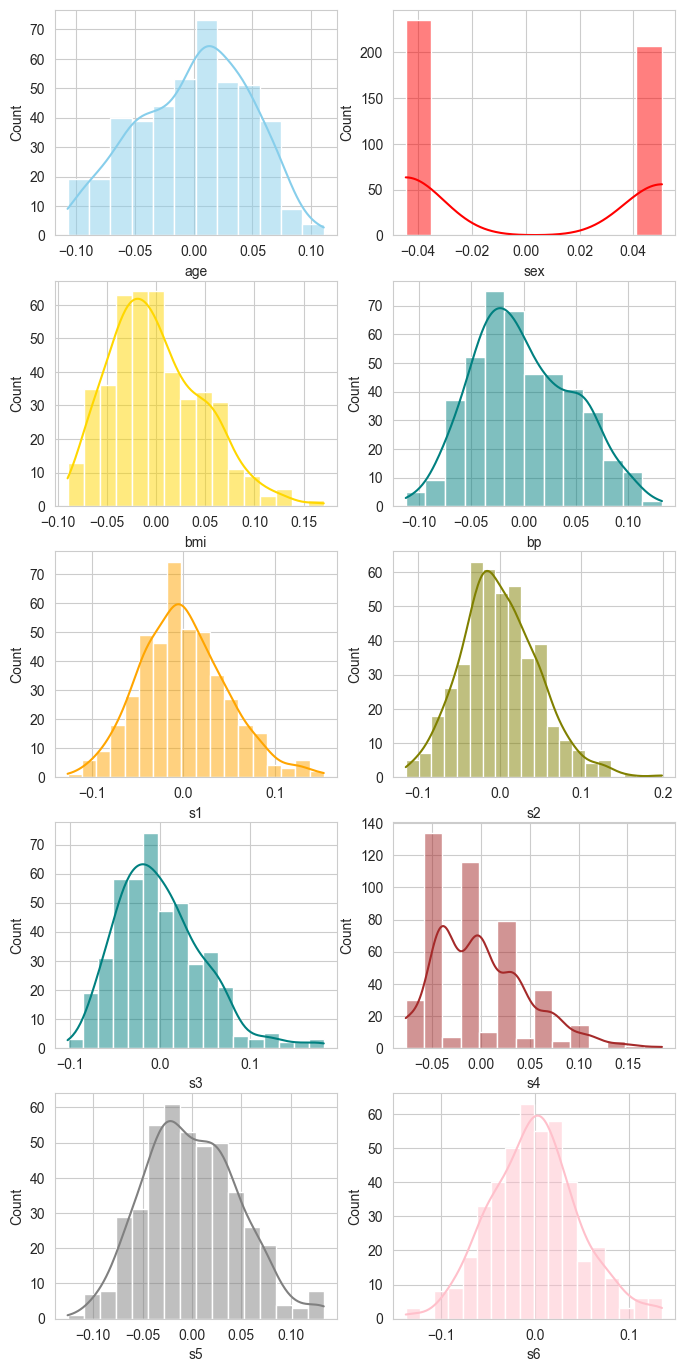

In [47]:
import seaborn as sns

fig, axs = plt.subplots(5, 2, figsize=(8, 17))

sns.histplot(data=X, x="age", kde=True, ax=axs[0, 0], color="skyblue", label="Age")
sns.histplot(data=X, x="sex", kde=True, ax=axs[0, 1], color="red", label="Sex")
sns.histplot(data=X, x="bmi", kde=True, ax=axs[1, 0], color="gold", label="bmi")
sns.histplot(data=X, x="bp", kde=True, ax=axs[1, 1], color="teal", label="bp")
sns.histplot(data=X, x="s1", kde=True, ax=axs[2, 0], color="orange", label="s1")
sns.histplot(data=X, x="s2", kde=True, ax=axs[2, 1], color="olive", label="s2")
sns.histplot(data=X, x="s3", kde=True, ax=axs[3, 0], color="teal", label="s3")
sns.histplot(data=X, x="s4", kde=True, ax=axs[3, 1], color="brown", label="s4")
sns.histplot(data=X, x="s5", kde=True, ax=axs[4, 0], color="grey", label="s5")
sns.histplot(data=X, x="s6", kde=True, ax=axs[4, 1], color="pink", label="s6") 

plt.show()

Соотношение полов:

In [48]:
X['sex'].value_counts()

-0.044642    235
 0.050680    207
Name: sex, dtype: int64

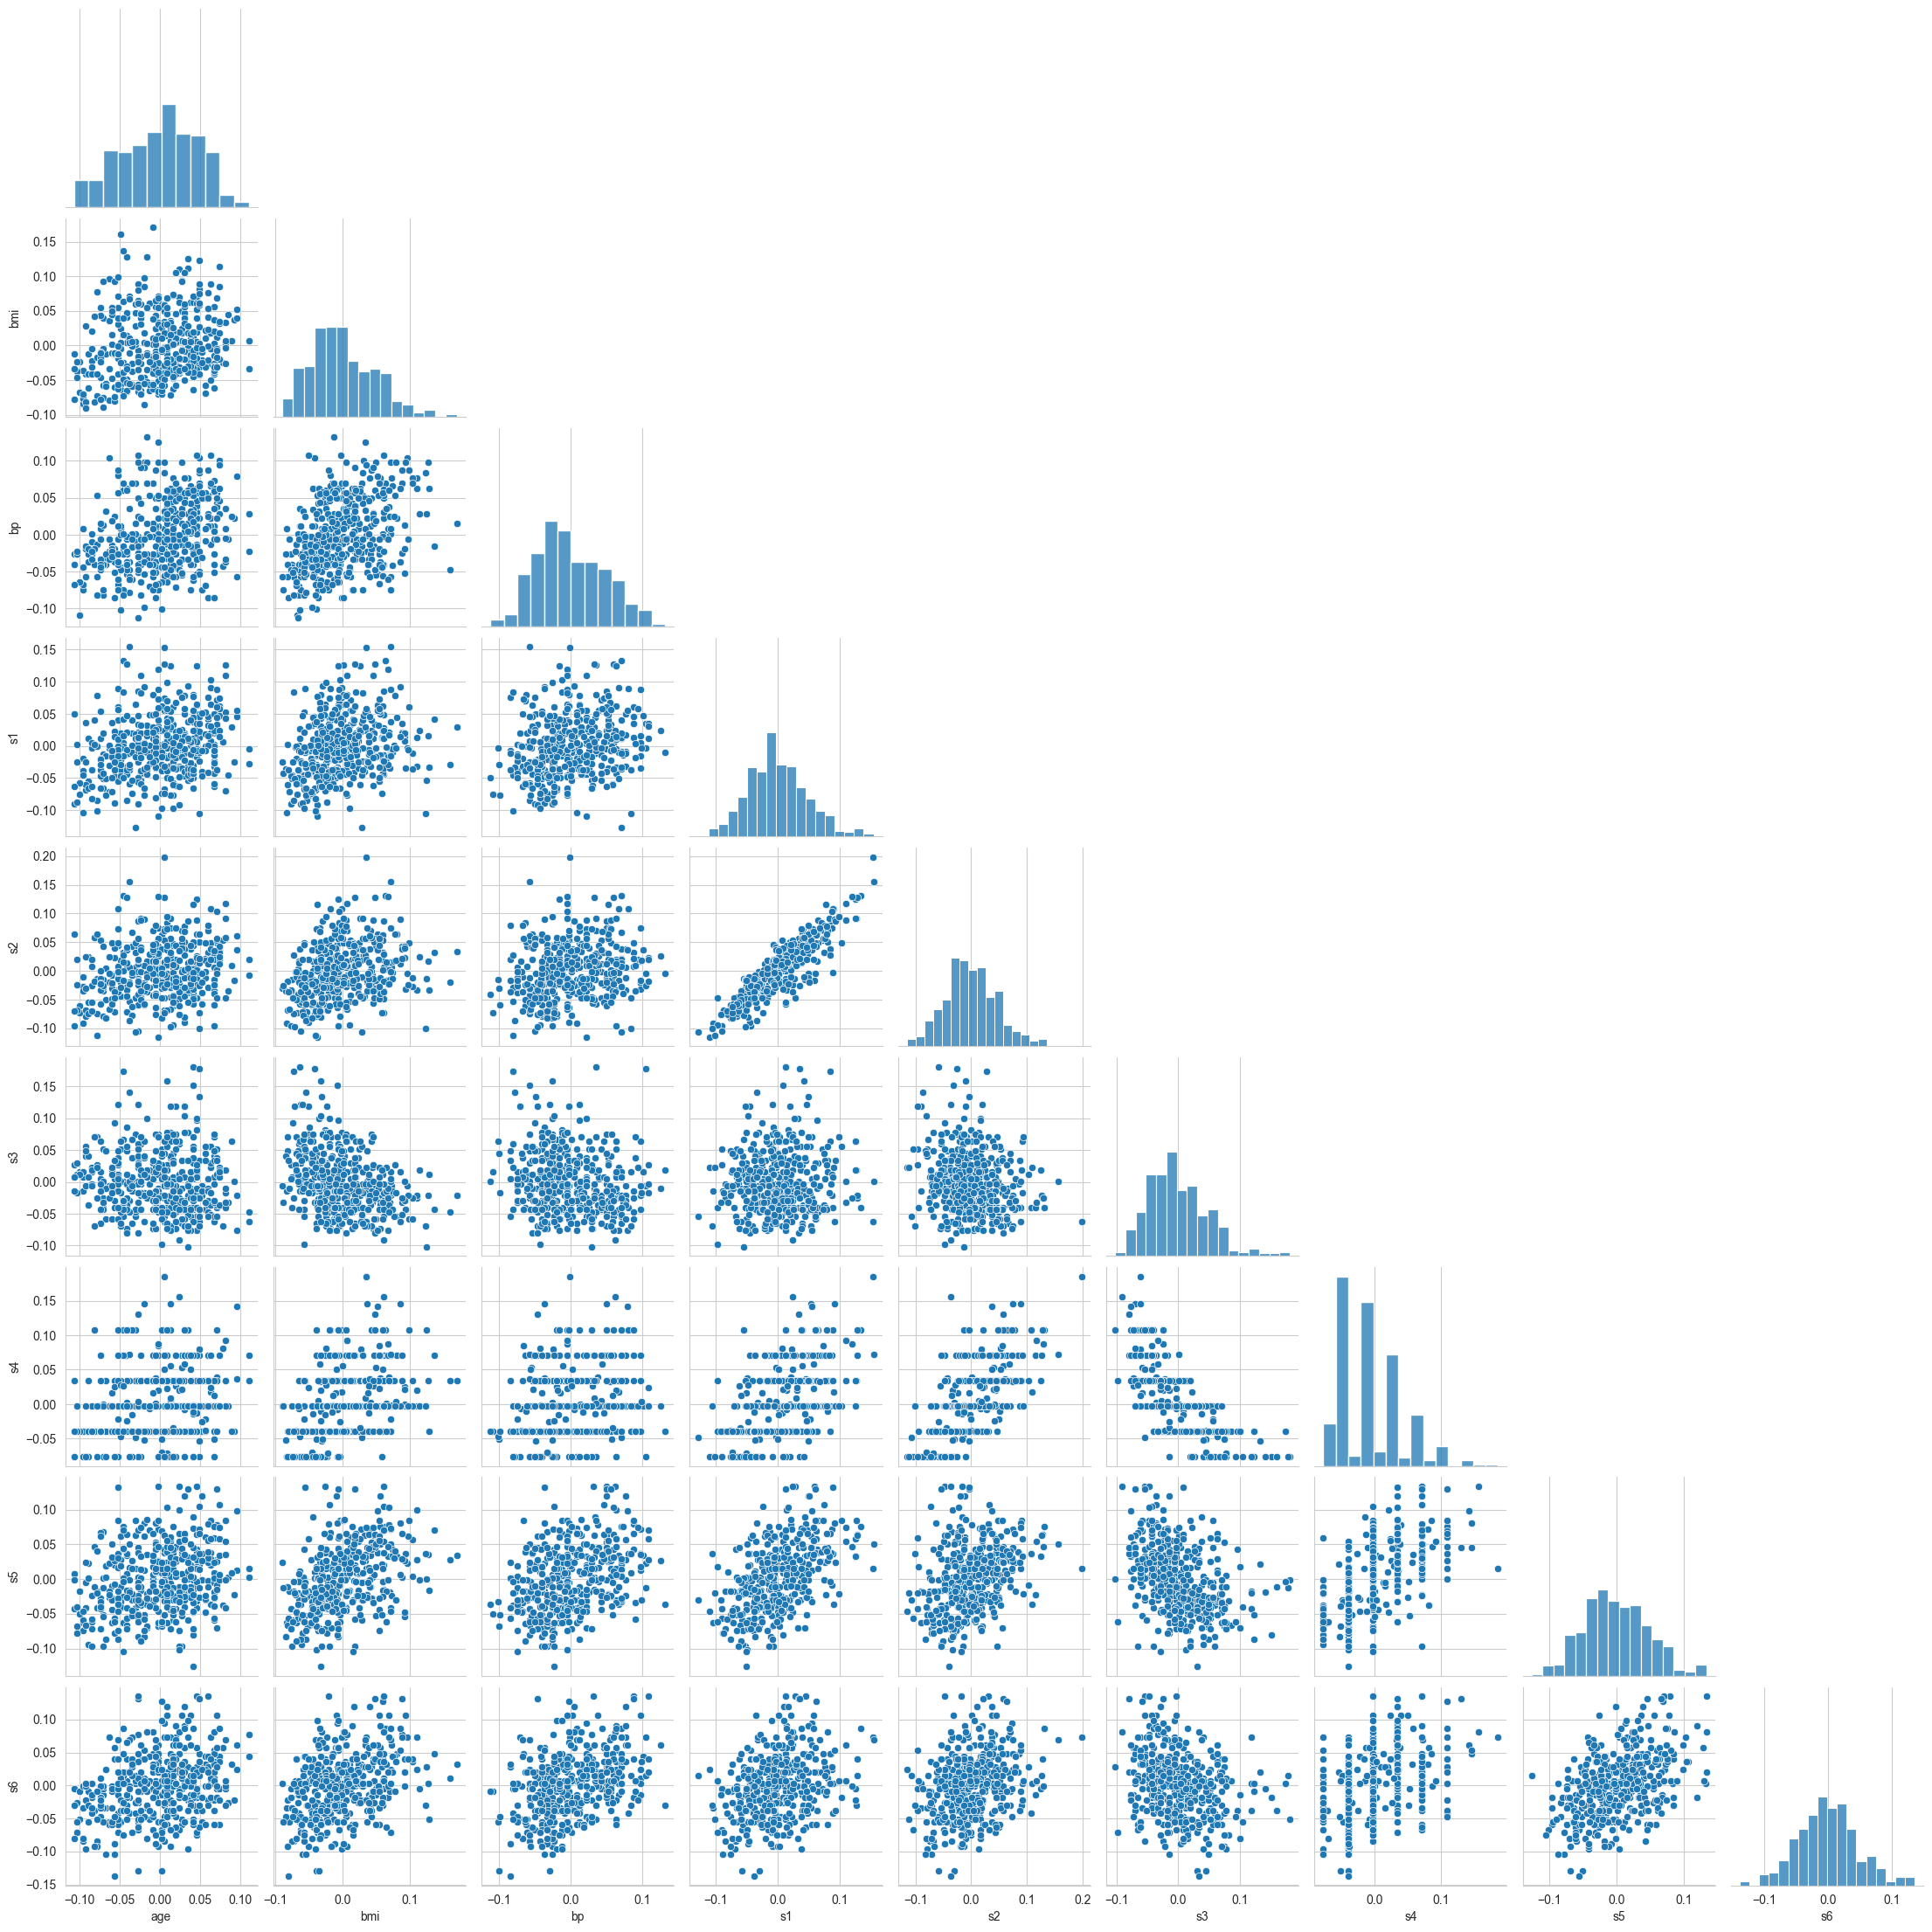

In [49]:
sns.pairplot(X.drop('sex', axis = 1), corner=True);

Признаки s1 и s2 хорошо линейно коррелируют друг с другом 

In [50]:
from sklearn.pipeline import Pipeline

Cтандартизация не нужна, но я потренировалась с пайплайном:))

In [51]:
from sklearn.compose import ColumnTransformer

В тренировочных данных только численные колонки, категориальных нет

In [52]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(),  X)
])

In [53]:
preprocessor.transformers

[('scaler',
  StandardScaler(),
            age       sex       bmi        bp        s1        s2        s3  \
  0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
  1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
  2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
  3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
  4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
  ..        ...       ...       ...       ...       ...       ...       ...   
  437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
  438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
  439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
  440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
  441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   
  
             s4  

In [87]:
knn_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", KNeighborsRegressor())
])

In [ ]:
knn_pipeline.fit(X, list(y))

In [ ]:
y_pred = knn_pipeline.predict(X)

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на тренировочных данных и сделайте предсказания.

Разделяем данные на тренировочные и тестовые:

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=SEED, 
                                                    test_size=0.2)

In [63]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [64]:
y_pred = knn_model.predict(X_test)

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [65]:
# TODO: r_squared, mse, mae in metrics.py

In [68]:
print(f'r_squared = {r_squared(y_pred, np.array(y_test))}')
print(f'mse = {mse(y_pred, np.array(y_test))}')
print(f'mae = {mae(y_pred, np.array(y_test))}')

r_squared = 0.351891188491006
mse = 3046.4008988764044
mae = 41.1191011235955


Значения метрик плохие..(((

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [110]:
from metrics import r_squared, mse, mae

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше. \
Использую функцию `find_best_k_regres` и метрику r_squared:

In [82]:
params = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50] 
train_metrics, test_metrics = find_best_k_regres(X_train, 
                                          np.array(y_train), 
                                          X_test, 
                                          np.array(y_test), 
                                          params, r_squared)

k_value  1
k_value  2
k_value  3
k_value  4
k_value  5
k_value  6
k_value  7
k_value  8
k_value  9
k_value  10
k_value  20
k_value  30
k_value  40
k_value  50


In [83]:
train_metrics

[1.0,
 0.7455279231760747,
 0.6340672825220957,
 0.6045263832722398,
 0.5827675174649873,
 0.565400946108786,
 0.5611787897542706,
 0.5525707239577917,
 0.5398525362151689,
 0.5341907713984612,
 0.5049500581592905,
 0.4864143049765892,
 0.4699438136238051,
 0.4652420368921022]

In [84]:
test_metrics

[-0.0011551548418875512,
 0.2531590701047838,
 0.23670122172677932,
 0.2916702321251813,
 0.351891188491006,
 0.3524760055459939,
 0.387205679669542,
 0.41584610299614533,
 0.42051439632556475,
 0.44354891344431135,
 0.447459771757475,
 0.4247010645571303,
 0.3992039166434207,
 0.38702138279197695]

На тестовом датасете лучшее значение метрики r2 показала модель с k = 20

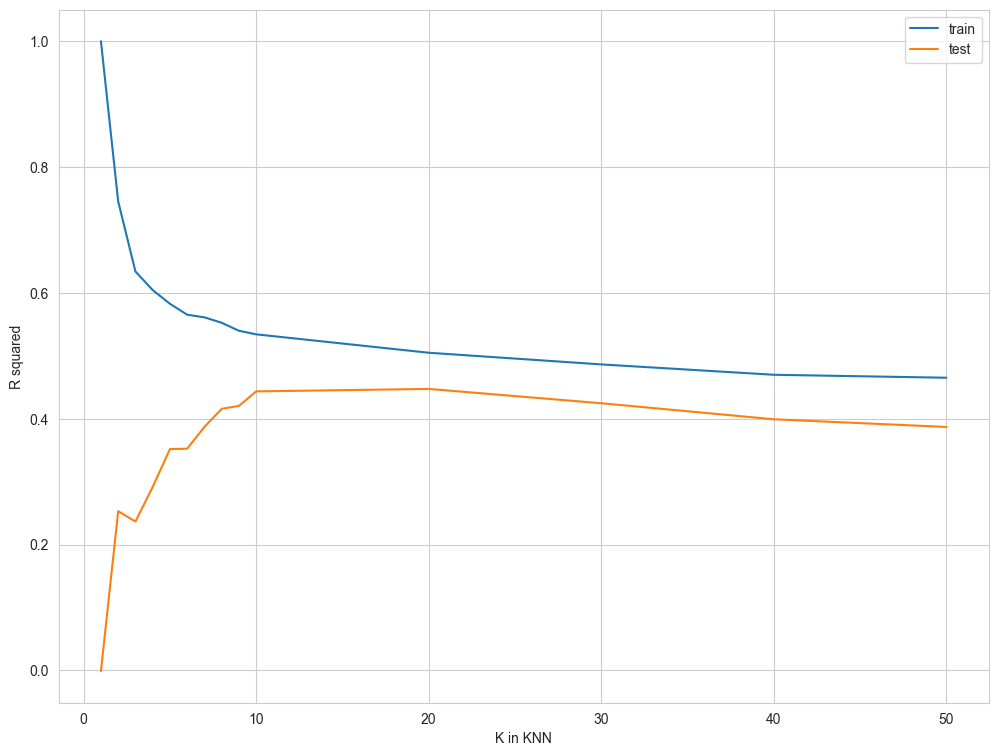

In [86]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("R squared");

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Было очень интересно, и местами довольно сложно) \
Но после того, как получилось реализовать что-то внятное, чувствуешь себя мега крутой и те часы, которые потратились на написание одного абзаца кода, уже не кажутся такими бесполезными)